##Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

In [2]:
def abrirImagenesEscaladas( carpeta, escala=32 ):
    # abre todas las imagenes de la carpeta, y las escala de tal forma que midan (escala x escala)px
    # devuelve las imagenes aplanadas -> vectores de tamano escala^2 con valores entre 0 y 1
    imagenes = []

    for dirpath, dirnames, filenames in os.walk(carpeta):
        for file in filenames:
            if file.endswith('DS_Store'):
                continue
            img = Image.open( os.path.join(carpeta, file) )
            img = img.resize((escala, escala))
            img.convert('1')
            img = np.asarray(img)
            if len(img.shape)==3:
                img = img[:,:,0].reshape((escala**2 )) / 255
            else:
                img = img.reshape((escala**2 )) / 255
            
            imagenes.append( img )

    return imagenes

In [3]:
# Data
if(True):
    img_train_sin_neumonia = abrirImagenesEscaladas('./chest_xray/train/NORMAL/')
    img_train_neumonia = abrirImagenesEscaladas('./chest_xray/train/PNEUMONIA/') # NO FUNCIONA :(
    img_test_sin_neumonia = abrirImagenesEscaladas('./chest_xray/test/NORMAL/')
    img_test_neumonia = abrirImagenesEscaladas('./chest_xray/test/PNEUMONIA/')

    data = (img_train_sin_neumonia, img_train_neumonia, img_test_sin_neumonia, img_test_neumonia)


In [4]:
def balancear_datos(imagenes_entrenamiento):

    img_train_sin_neumonia = imagenes_entrenamiento[0]
    img_train_neumonia =imagenes_entrenamiento[1]
    img_test_sin_neumonia =imagenes_entrenamiento[2]
    img_test_neumonia = imagenes_entrenamiento[3]

    # MAX NUMBER OF IMAGES
    n_train = min(len(img_train_sin_neumonia), len(img_train_neumonia))
    n_test = min(len(img_test_sin_neumonia), len(img_test_neumonia))

    # BALANCE
    img_train_sin_neumonia = img_train_sin_neumonia[:n_train]
    img_train_neumonia = img_train_neumonia[:n_train]
    img_test_sin_neumonia = img_test_sin_neumonia[:n_test]
    img_test_neumonia = img_test_neumonia[:n_test]

    
    return (img_train_sin_neumonia, img_train_neumonia, img_test_sin_neumonia, img_test_neumonia)

In [5]:
data = balancear_datos(data)

## Ejercicio 1

Derivadas Parciales

In [6]:
#funcion f
def F(i,w,b):
    """_summary_

    Args:
        i (Vector): imagen reshaped a un vector de tamano 32^2
        w (Vector): Pesos de la red
        b (Float): Bias de la red

    Returns:
        probabolidad: 0 < p < 1: Probabilidad de que la imagen sea un 1 (Tiene neumonia)
    """
    tan = np.tanh(np.dot(w,i)+b)
    return (tan + 1)/2

In [7]:
# Derivada de L con respecto a W
def L_w(i,w,b,d):
    """_summary_

    Args:
        i (Vector): imagen reshaped a un vector de tamano 32^2
        w (Vector): Pesos de la red
        b (Float): Bias de la red

    Returns:
        Vector: Gradiente de la probabilidad con respecto a los pesos
    """
    # t0=tanh(b+W⊤⋅i)
    #return: (1−t0^2)⋅((1+t0)/2−d)⋅i
    
    t0 = np.tanh(np.dot(w,i)+b)
    return (1-t0**2)*(((1+t0)/2)-d) * i

In [8]:
# Derivada de L con respecto a b
def L_b(i,w,b,d):
    """_summary_

    Args:
        i (Vector): imagen reshaped a un vector de tamano 32^2
        w (Vector): Pesos de la red
        b (Float): Bias de la red

    Returns:
        Float: Gradiente de la probabilidad con respecto al bias
    """
    #t0=tanh(b+W⊤⋅i)
    #(1−t0^2)⋅((1+t0)/2−d)   
    t0 = np.tanh(np.dot(w,i)+b)
    return (1-t0**2)*(((1+t0)/2)-d)

## Ejercicio 2

Implementar el metodo de descenso por gradiente y optimizar los parametros de la funcion f para el conjunto de datos de entrenamiento. Para esto les recomendamos que trabajen con un subconjunto de los datos que tenga una cantidad parecida de imagenes con y sin neumonia

In [9]:
def desenso_gradiente(w,b,gradiente_w, gradiente_b, d, alpha=0.1):
    """_summary_

    Args:
        imagenes_entrenamiento (List): Lista de imagenes de tamano 32^2
        w (Vector): Pesos de la red
        b (Float): Bias de la red
        alpha (Float): Learning rate

    Returns:
        Tuple: Pesos y bias actualizados

    """
    w = w - alpha * gradiente_w
    b = b - alpha * gradiente_b
    return w,b



## Ejercicio 3

Calcular el error cuadratico durante la optimizacion para el conjunto de entrenamiento y para el conjunto de testing. Generar las visualizaciones correspondientes.

In [43]:
def train(datos, alpha=0.005, epochs = 5,seed = 42):
    """_summary_

    Args:
        datos (tuple): Tupla de dos listas, la primera con las imagenes Normales y la segunda con las imagenes con Neumonia 
        w (Vector): Pesos de la red
        b (Float): Bias de la red
        alpha (Float): Learning rate
        epochs (Int): Numero de iteraciones

    Returns:
        Tuple: Pesos y bias actualizados
    """
    # inicioamos con pesos aleatorios
    # set numpy seed
    

    datos_sin_neumonia = datos[0]
    datos_con_neumonia = datos[1]

    # # Normalización de los datos de prueba
    # datos_sin_neumonia = [x / 255.0 for x in datos_sin_neumonia]
    # datos_con_neumonia = [x / 255.0 for x in datos_con_neumonia]
    
    np.random.seed(seed)
    w = np.random.randn(datos_sin_neumonia[0].shape[0])
    b = np.random.randn(1)
    
    
    print(len(datos_sin_neumonia)+len(datos_con_neumonia),len(datos_sin_neumonia)/len(datos_con_neumonia))
    
    error = 0
    errores = []
    for _ in range(epochs):  
        error = 0
        gradiente_w = np.zeros_like(w)
        gradiente_b = 0
        
        # Entrenamiento con imágenes sin neumonía
        label = 0
        for i in datos_sin_neumonia: 
            
            gradiente_w += L_w(i,w,b,label)
            gradiente_b += L_b(i,w,b,label)
            error += (F(i,w,b) - label)**2 # Falta arreglar esto
            
        # w,b = desenso_gradiente(w,b,gradiente_w,gradiente_b,label,alpha)
            
        # Entrenamiento con imágenes con neumonía
        label = 1
        for i in datos_con_neumonia:
            gradiente_w += L_w(i,w,b,label)
            gradiente_b += L_b(i,w,b,label)
            error += (F(i,w,b) - label)**2 # Falta arreglar esto
        
        # # Promediar los gradientes acumulados
        # gradiente_w /= (len(datos_sin_neumonia) + len(datos_con_neumonia))
        # gradiente_b /= (len(datos_sin_neumonia) + len(datos_con_neumonia))
        
        # Actualización de los parámetros
        w, b = desenso_gradiente(w, b, gradiente_w, gradiente_b, alpha)
        
        # Almacenar el error cuadrático para visualización
        errores.append(error / (len(datos_sin_neumonia) + len(datos_con_neumonia)))
       
        
        # Decaer la tasa de aprendizaje
        alpha *= 0.95
        
        # Mostrar el error de la epoch actual
        print(f"\r{error}",end='',)
    
    plt.plot(errores)
    plt.xlabel('Epoch')
    plt.ylabel('Error Cuadrático')
    plt.title('Error Cuadrático durante el Entrenamiento')
    plt.show()

    return w,b

In [37]:
def test(w,b,datos, error_minimo):
    """_summary_

    Args:
        w (Vector): Pesos de la red
        b (Float): Bias de la red
        datos (tuple): Tupla de dos listas, la primera con las imagenes Normales y la segunda con las imagenes con Neumonia 

    Returns:
        Float: Accuracy
    """
    datos_sin_neumonia = datos[0]
    datos_con_neumonia = datos[1]
    correctos = 0
    for i in datos_sin_neumonia:
        if F(i,w,b) < error_minimo:
            correctos += 1
    for i in datos_con_neumonia:
        if F(i,w,b) >= error_minimo:
            correctos += 1
    return correctos/(len(datos_sin_neumonia)+len(datos_con_neumonia))

4706 0.4018468871015788
[1349.0000337]]

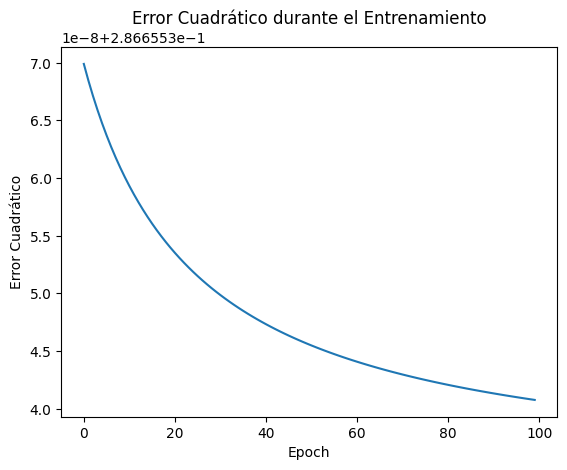

0.625

In [44]:
train_sin, train_con, test_sin, test_con = data


w_res, b_res = train(
    (train_sin, train_con),
    alpha=0.005,
    epochs = 100,
    seed = 42
    )
test(w_res,b_res,(test_sin,test_con), 0.5)

## Ejercicio 4
Analizar el impacto del parametro α en la convergencia del metodo. Tomar un rango
de 5 valores posibles y analizar la convergencia para el conjunto de testing para los distintos valores de α.

In [26]:
def analizar_convergencia(errores):
    if len(errores) < 2:
        return float('inf') 
    return abs(errores[-1] - errores[-2]) / errores[-2]

In [32]:
def train(datos, alpha=0.005, epochs = 5,seed = 42):
    """_summary_

    Args:
        datos (tuple): Tupla de dos listas, la primera con las imagenes Normales y la segunda con las imagenes con Neumonia 
        w (Vector): Pesos de la red
        b (Float): Bias de la red
        alpha (Float): Learning rate
        epochs (Int): Numero de iteraciones

    Returns:
        Tuple: Pesos y bias actualizados
    """
    # inicioamos con pesos aleatorios
    # set numpy seed
    

    datos_sin_neumonia = datos[0]
    datos_con_neumonia = datos[1]
    
    # # Normalización de los datos de prueba
    # datos_sin_neumonia = [x / 255.0 for x in datos_sin_neumonia]
    # datos_con_neumonia = [x / 255.0 for x in datos_con_neumonia]

    np.random.seed(seed)
    w = np.random.randn(datos_sin_neumonia[0].shape[0])
    b = np.random.randn(1)
    
    
    print(len(datos_sin_neumonia)+len(datos_con_neumonia),len(datos_sin_neumonia)/len(datos_con_neumonia))
    
    error = 0
    errores = []
    for _ in range(epochs):  
        error = 0
        gradiente_w = np.zeros_like(w)
        gradiente_b = 0
        
        # Entrenamiento con imágenes sin neumonía
        label = 0
        for i in datos_sin_neumonia: 
            
            gradiente_w += L_w(i,w,b,label)
            gradiente_b += L_b(i,w,b,label)
            error += (F(i,w,b) - label)**2 # Falta arreglar esto
            
        # w,b = desenso_gradiente(w,b,gradiente_w,gradiente_b,label,alpha)
            
        # Entrenamiento con imágenes con neumonía
        label = 1
        for i in datos_con_neumonia:
            gradiente_w += L_w(i,w,b,label)
            gradiente_b += L_b(i,w,b,label)
            error += (F(i,w,b) - label)**2 # Falta arreglar esto
            
        gradiente_w /= (len(datos_sin_neumonia) + len(datos_con_neumonia))
        gradiente_b /= (len(datos_sin_neumonia) + len(datos_con_neumonia))
        
        w, b = desenso_gradiente(w, b, gradiente_w, gradiente_b, alpha)
        
        errores.append(error / (len(datos_sin_neumonia) + len(datos_con_neumonia)))
        
        alpha *= 0.95
        
        print(f"Epoch {_ + 1}/{epochs} - Error: {errores[-1]}")
    
        # Decaer la tasa de aprendizaje
        alpha *= 0.95
        
        # Mostrar el error de la epoch actual
        print(f"\r{error}",end='',)
    
        diferencia = analizar_convergencia(errores)
        if diferencia < 1e-20:
            print(f"Convergio en el epoch: {_ + 1} con aplha: {alpha}")
            break
       
        
        
    plt.plot(errores)
    plt.xlabel('Epoch')
    plt.ylabel('Error Cuadrático')
    plt.title('Error Cuadrático durante el Entrenamiento')
    plt.show()

    return w,b

2698 1.0
Epoch 1/100 - Error: [0.47444973]
Convergio en el epoch: 0 con aplha: 0.095


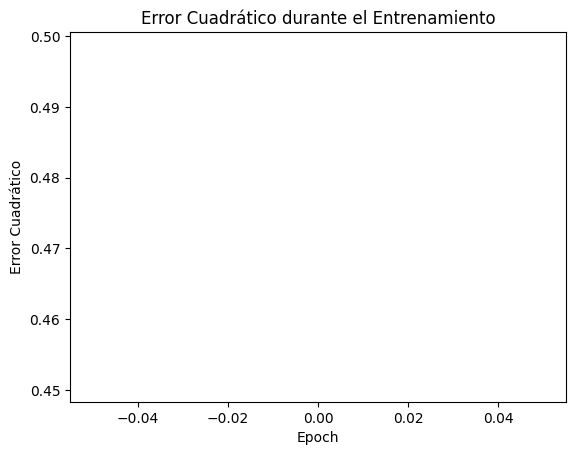

2698 1.0
Epoch 1/100 - Error: [0.47444973]
Convergio en el epoch: 0 con aplha: 0.0475


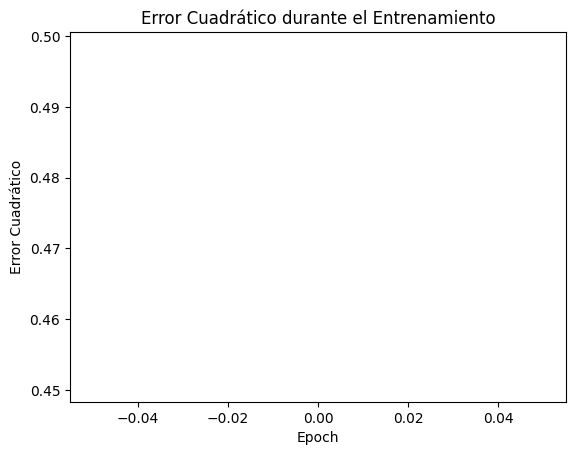

2698 1.0
Epoch 1/100 - Error: [0.47444973]
Convergio en el epoch: 0 con aplha: 0.0095


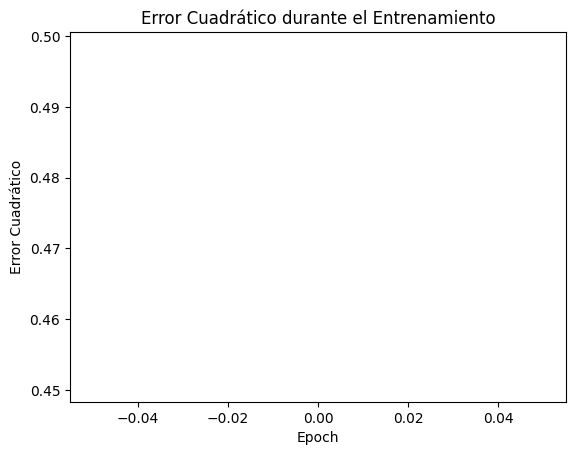

2698 1.0
Epoch 1/100 - Error: [0.47444973]
Convergio en el epoch: 0 con aplha: 0.00475


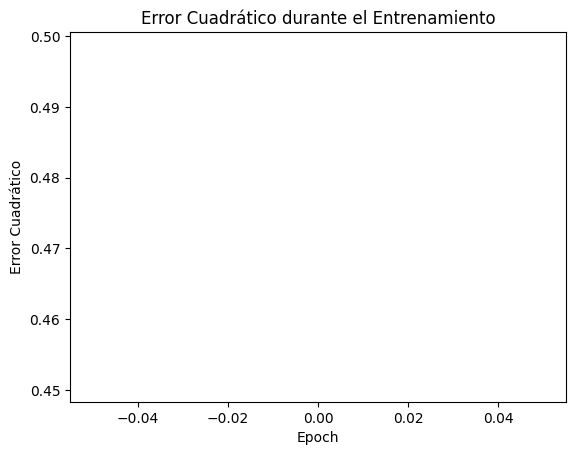

2698 1.0
Epoch 1/100 - Error: [0.47444973]
Convergio en el epoch: 0 con aplha: 0.00095


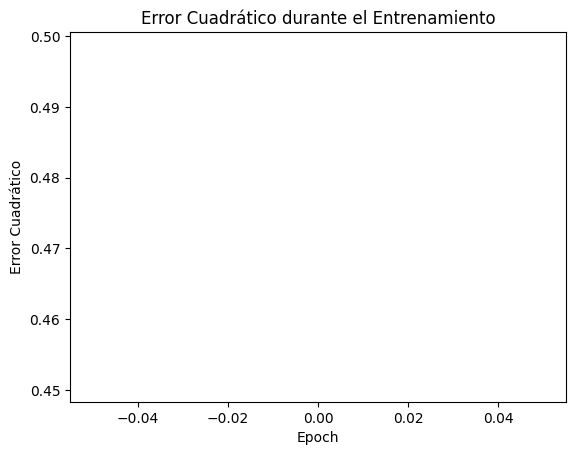

In [33]:
alphas = [0.1, 0.05, 0.01, 0.005, 0.001]

for i in alphas:
    w_res, b_res = train(
        (train_sin, train_con),
        alpha=i,
        epochs = 100,
        seed = 42
        )
    test(w_res,b_res,(test_sin,test_con), 0.5)

El valor de alpha que mejora una convergencia en la menor cantidad de epochs es: 

Ver como graficar esto x seria los aplhas y y seria la cantidad d epochs 

## Ejercicio 5

¿Como impacta el tamaño del escalado de las imagenes en la efectividad del metodo? ¿Y en el tiempo de computo?. Realizar los experimentos y graficos acordes para estudiar estas limitaciones.

## Ejercicio 6 

Para el valor de α que tenga mejor valor de convergencia, generar la matriz de confusion y analizar brevemente la efectividad del m´etodo.